In [24]:
from sdo.sood.data.sdo_ml_v2_dataset import SDOMLv2DataModule

In [25]:
from pathlib import Path
import numpy as np
import os 
import sunpy
from sunpy.visualization.colormaps import cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torchvision
import torch
import torchvision.transforms.functional as F

#inspect an image

#Channels that correspond to HMI Magnetograms 
HMI_WL = ['Bx','By','Bz']
#A colormap for visualizing HMI
HMI_CM = LinearSegmentedColormap.from_list("bwrblack", ["#0000ff","#000000","#ff0000"])

def channel_to_map(name):
    """Given channel name, return colormap"""
    return HMI_CM if name in HMI_WL else cm.cmlist.get('sdoaia%d' % int(name))

def get_clip(X,name):
    """Given an image and the channel name, get the right clip"""
    return get_signed_pct_clip(X) if name in HMI_WL else get_pct_clip(X)

def get_pct_clip(X):
    """Return the 99.99th percentile"""
    return (0,np.quantile(X.ravel(),0.999))

def get_signed_pct_clip(X):
    """Return the 99.99th percentile by magnitude, but symmetrize it so 0 is in the middle"""
    v = np.quantile(np.abs(X.ravel()),0.999)
    return (-v,v)

def vis(X, cm, clip):
    """Given image, colormap, and a clipping, visualize results"""
    Xc = np.clip((X-clip[0])/(clip[1]-clip[0]),0,1)
    Xcv = cm(Xc)
    return (Xcv[:,:,:3]*255).astype(np.uint8)

def show_grid(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(figsize=(24,24), ncols=4, nrows=int(len(imgs)/4), squeeze=False)
    row = 0
    for i, img in enumerate(imgs):
        col = i % 4
        if i != 0 and i % 4 == 0:
            row = row + 1
        axs[row, col].imshow(img)
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [3]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_small.zarr/", channel="193A").train_dataloader()

discovered the following zarr directory structure
/
 └── 2010
     ├── 131A (6135, 512, 512) float32
     ├── 1600A (6136, 512, 512) float32
     ├── 1700A (6135, 512, 512) float32
     ├── 171A (6135, 512, 512) float32
     ├── 193A (6135, 512, 512) float32
     ├── 211A (6136, 512, 512) float32
     ├── 304A (6134, 512, 512) float32
     ├── 335A (6135, 512, 512) float32
     └── 94A (6136, 512, 512) float32
found 239 images
discovered the following zarr directory structure
/
 └── 2010
     ├── 131A (6135, 512, 512) float32
     ├── 1600A (6136, 512, 512) float32
     ├── 1700A (6135, 512, 512) float32
     ├── 171A (6135, 512, 512) float32
     ├── 193A (6135, 512, 512) float32
     ├── 211A (6136, 512, 512) float32
     ├── 304A (6134, 512, 512) float32
     ├── 335A (6135, 512, 512) float32
     └── 94A (6136, 512, 512) float32
found 239 images
splitting datatset with 239 into [191, 48]


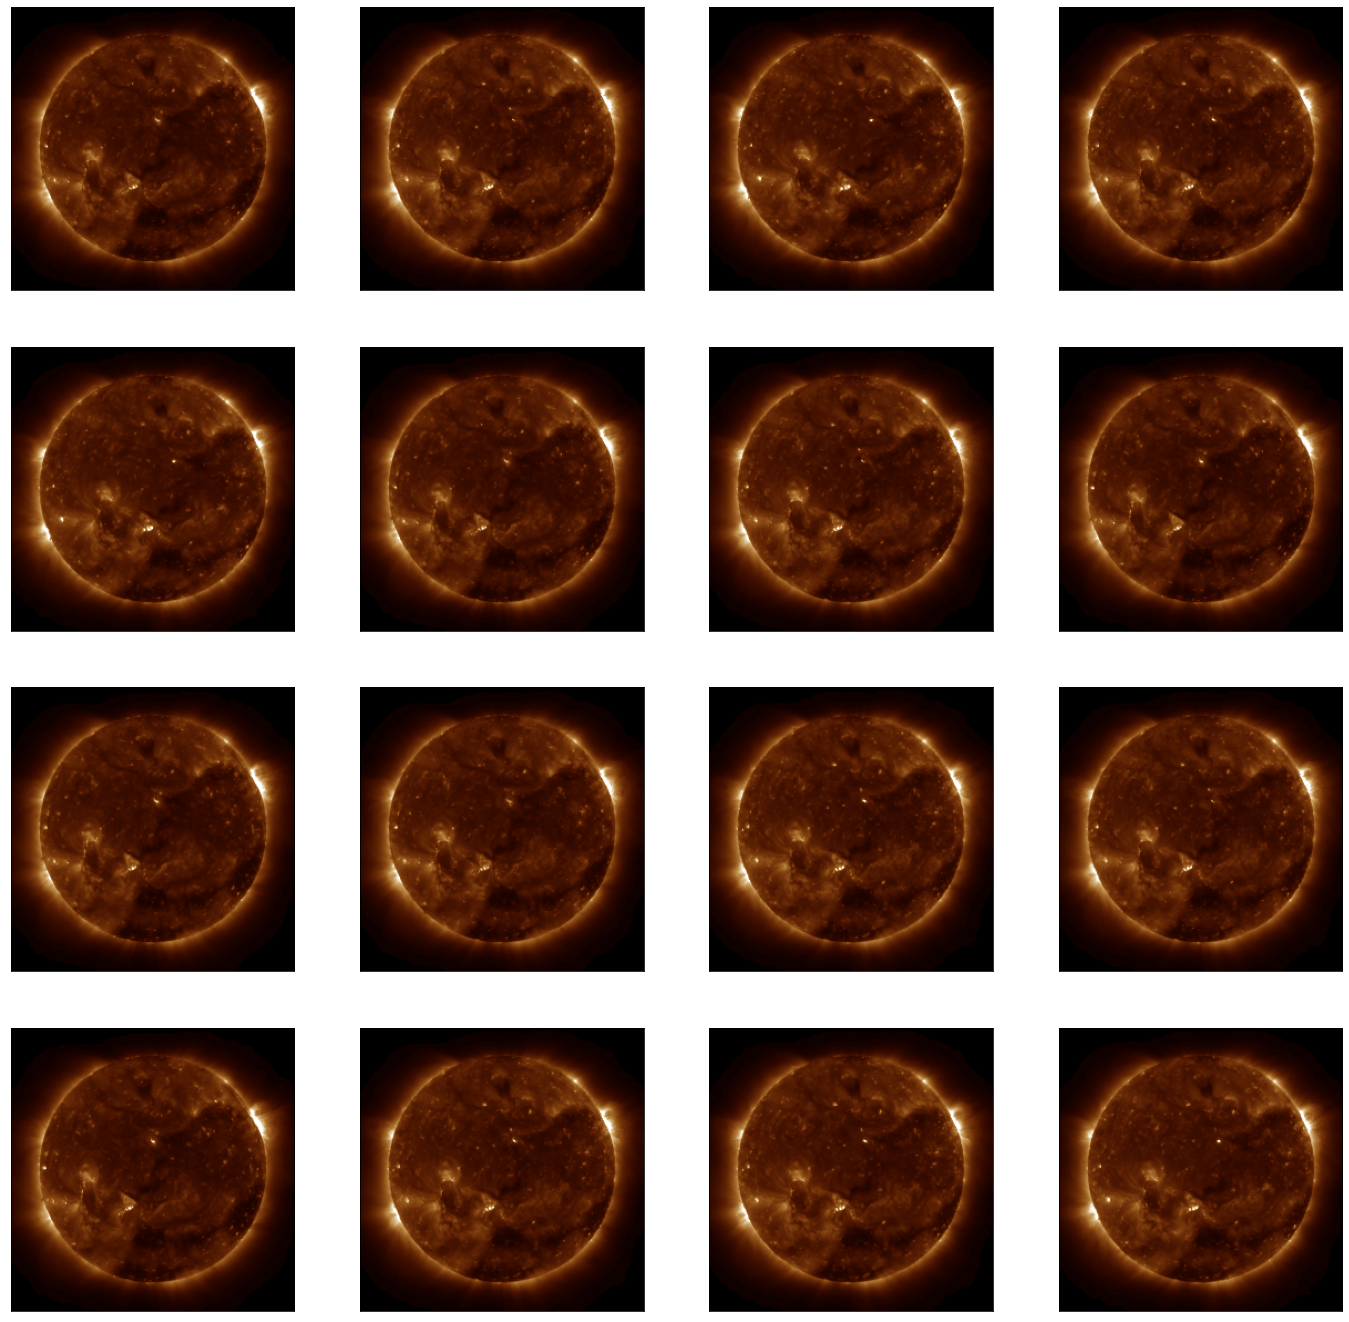

In [4]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(193), get_clip(x, 171))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [26]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import Compose, Resize, Normalize, Lambda
import math
import pytorch_lightning as pl
import gcsfs
import zarr
import pandas as pd
import dask.array as da

# refer to http://jsoc.stanford.edu/How_toget_data.html
hmi_date_format = '%Y.%m.%d_%H:%M:%S_TAI'

class SDOMLv2NumpyDataset(Dataset):
    def __init__(
            self,
            storage_root="fdl-sdoml-v2/sdomlv2_small.zarr/",
            n_items=None,
            year="2010",
            channel="171A",
            start="2010-08-28 00:00:00",
            end="2010-08-28 23:59:59",
            freq="6T",
            transforms=None):
        """Dataset which loads Numpy npz files
        Args:
            base_dir ([str]): [Directory in which the npz files are.]
            mode (str, optional): [train or val, TODO implement val split]. Defaults to "train".
            n_items ([type], optional): [Number of items in on iteration, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
            file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*.npz".
            data_key (str, optional): [Data key used to load data from the npz array]. Defaults to 'x'.
            transforms ([type], optional): [Transformations to do after loading the data -> pytorch data transforms]. Defaults to None
        """
        # TODO only load required channels
        gcs = gcsfs.GCSFileSystem(access="read_only")
        store = gcsfs.GCSMap(storage_root, gcs=gcs, check=False)
        root = zarr.group(store)
        print("discovered the following zarr directory structure")
        print(root.tree())

        if year:
            by_year = root[year]
        else:
            by_year = root[:]

        if channel:
            data = by_year[channel]
        else:
            data = by_year[:]

        if freq:
            # temporal downsampling
            t_obs = np.array(data.attrs["T_OBS"])
            df_time = pd.DataFrame(t_obs, index=np.arange(
                np.shape(t_obs)[0]), columns=["Time"])
            # TODO for HMI the date format is different 2010.05.01_00:12:04_TAI
            format = None
            if channel in ['Bx','By','Bz']:
                format = hmi_date_format
            df_time["Time"] = pd.to_datetime(df_time["Time"], format=format, utc=True)
            
            # select times at a frequency of freq (e.g. 12T)
            selected_times = pd.date_range(
                start=start, end=end, freq=freq, tz="UTC"
            )
            selected_index = []
            for i in selected_times:
                selected_index.append(np.argmin(abs(df_time["Time"] - i)))
            time_index = [x for x in selected_index if x > 0]
            all_images = da.from_array(data)[time_index, :, :]
            attrs = {keys: [values[idx] for idx in time_index]
                     for keys, values in data.attrs.items()}
        else:
            attrs = data.attrs
            all_images = da.from_array(data)

        self.transforms = transforms
        self.all_images = all_images
        self.attrs = attrs

        self.data_len = len(self.all_images)
        print(f"found {len(self.all_images)} images")
        if n_items is None:
            self.n_items = self.data_len
        else:
            self.n_items = int(n_items)

    def __len__(self):
        return self.n_items

    def __getitem__(self, item):
        if item >= self.n_items:
            raise StopIteration()

        idx = item % self.data_len
        image = self.all_images[idx, :, :]

        attrs = dict([(key, self.attrs[key][idx])
                     for key in self.attrs.keys()])
        
        # Pytorch does not support NoneType items
        attrs = {k:v for k,v in attrs.items() if v is not None}
    
        torch_arr = torch.from_numpy(np.array(image))
        # convert to 1 x H x W, to be in compatible torchvision format
        torch_arr = torch_arr.unsqueeze(dim=0)
        if self.transforms is not None:
            torch_arr = self.transforms(torch_arr)
        
        return torch_arr, attrs


# TODO are these values still applicable for the new correction factors?
# Same preprocess as github.com/i4Ds/SDOBenchmark
CHANNEL_PREPROCESS = {
    "94A": {"min": 0.1, "max": 800, "scaling": "log10"},
    "131A": {"min": 0.7, "max": 1900, "scaling": "log10"},
    "171A": {"min": 5, "max": 3500, "scaling": "log10"},
    "193A": {"min": 20, "max": 5500, "scaling": "log10"},
    "211A": {"min": 7, "max": 3500, "scaling": "log10"},
    "304A": {"min": 0.1, "max": 3500, "scaling": "log10"},
    "335A": {"min": 0.4, "max": 1000, "scaling": "log10"},
    "1600A": {"min": 10, "max": 800, "scaling": "log10"},
    "1700A": {"min": 220, "max": 5000, "scaling": "log10"},
    "4500A": {"min": 4000, "max": 20000, "scaling": "log10"},
    "continuum": {"min": 0, "max": 65535, "scaling": None},
    "magnetogram": {"min": -250, "max": 250, "scaling": None},
    "Bx": {"min": -250, "max": 250, "scaling": None},
    "By": {"min": -250, "max": 250, "scaling": None},
    "Bz": {"min": -250, "max": 250, "scaling": None},
}


def get_default_transforms(target_size=128, channel="171"):
    """Returns a Transform which resizes 2D samples (1xHxW) to a target_size (1 x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
        channel (str, optional): [The SDO channel]. Defaults to 171.
    Returns:
        [Transform]
    """

    """
    Apply the normalization necessary for the sdo-dataset. Depending on the channel, it:
      - flips the image vertically
      - clips the "pixels" data in the predefined range (see above)
      - applies a log10() on the data
      - normalizes the data to the [0, 1] range
      - normalizes the data around 0 (standard scaling)

    :param channel: The kind of data to preprocess
    :param resize: Optional size of image (integer) to resize the image
    :return: a transforms object to preprocess tensors
    """

    # also refer to https://pytorch.org/vision/stable/transforms.html
    # and https://gitlab.com/jdonzallaz/solarnet-thesis/-/blob/master/solarnet/data/transforms.py
    preprocess_config = CHANNEL_PREPROCESS[channel]

    if preprocess_config["scaling"] == "log10":
        # TODO why was vflip(x) used here in SolarNet?
        def lambda_transform(x): return torch.log10(torch.clamp(
            x,
            min=preprocess_config["min"],
            max=preprocess_config["max"],
        ))
        mean = math.log10(preprocess_config["min"])
        std = math.log10(preprocess_config["max"]) - \
            math.log10(preprocess_config["min"])
    else:
        def lambda_transform(x): return torch.clamp(
            x,
            min=preprocess_config["min"],
            max=preprocess_config["max"],
        )
        mean = preprocess_config["min"]
        std = preprocess_config["max"] - preprocess_config["min"]

    transforms = Compose(
        [Resize((target_size, target_size)),
         #  Lambda(lambda_transform),
         #  Normalize(mean=[mean], std=[std]),
         #  # required to remove strange distribution of pixels (everything too bright)
         #  Normalize(mean=(0.5), std=(0.5))
         ]
    )
    return transforms


class SDOMLv2DataModule(pl.LightningDataModule):
    def __init__(self,
                 storage_root: str = "fdl-sdoml-v2/sdomlv2_small.zarr/",
                 batch_size: int = 16,
                 n_items: int = None,
                 pin_memory: bool = False,
                 num_workers: int = 0,
                 drop_last: bool = False,
                 target_size: int = 256,
                 channel: str = "171A",
                 year="2010",
                 start="2010-08-28 00:00:00",
                 end="2010-08-28 23:59:59",
                 freq="6T",
                 shuffle: bool = False):
        """
        Creates a LightningDataModule for the SDO Ml v2 dataset

        The header information can be retrieved as the second argument when enumerating the loader

        >>> loader = SDOMLv2DataModule(channel="171A").train_dataloader()
        >>> for batch_idx, batch in enumerate(loader):
        >>>     X, headers  = batch

        Args:
            storage_root ([str]): [Root path in the GCS bucket containing the zarr archives.]
            batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
            n_items ([int], optional): [Number of items in the dataset, by default number of files in the loaded set 
                                            but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
            pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
            num_workers (int, optional): [See pytorch DataLoader]. Defaults to 0.
            drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
            target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 256.
            channel (str, optional): [Channel name that should be used]. Defaults to "171A".
            year (str, optional): [Allows to prefilter the dataset by year, useful for train/test splits]. Defaults to "2010".
            start (str, optional): [Allows to restrict the dataset temporally, only works in combination with freq]. Defaults to "2010-08-28 00:00:00".
            end (str, optional): [Allows to restrict the dataset temporally, only works in combination with freq]. Defaults to "2010-08-28 23:59:59".
            freq (str, optional): [Allows to downsample the dataset temporally, should be bigger than the min interval for the observed channel]. Defaults to "6T".
            shuffle (bool, optional): [See pytorch DataLoader]. Defaults to False.
        """
        super().__init__()

        transforms = get_default_transforms(
            target_size=target_size, channel=channel)

        dataset = SDOMLv2NumpyDataset(
            storage_root=storage_root,
            year=year,
            start=start,
            end=end,
            freq=freq,
            n_items=n_items,
            channel=channel,
            transforms=transforms,
        )

        self.dataset_test = SDOMLv2NumpyDataset(
            storage_root=storage_root,
            year=year,
            start=start,
            end=end,
            freq=freq,
            n_items=n_items,
            channel=channel,
            transforms=transforms,
        )

        # TODO investigate the use of a ChunkSampler in order to improve data loading performance https://gist.github.com/wassname/8ae1f64389c2aaceeb84fcd34c3651c3
        # TODO implement temporal split
        num_samples = len(dataset)
        splits = [int(math.floor(num_samples*0.8)),
                  int(math.ceil(num_samples * 0.2))]
        print(f"splitting datatset with {num_samples} into {splits}")
        self.dataset_train, self.dataset_val = random_split(dataset, splits)
        self.batch_size = batch_size
        self.pin_memory = pin_memory
        self.num_workers = num_workers
        self.drop_last = drop_last
        self.shuffle = shuffle

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          pin_memory=self.pin_memory,
                          drop_last=self.drop_last,)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          pin_memory=self.pin_memory,
                          drop_last=self.drop_last,)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          pin_memory=self.pin_memory,
                          drop_last=self.drop_last,)

    def predict_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          pin_memory=self.pin_memory,
                          drop_last=self.drop_last,)


In [27]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_hmi_small.zarr/", channel="Bx", freq="1h", batch_size=16).train_dataloader()

discovered the following zarr directory structure
/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32
found 24 images
discovered the following zarr directory structure
/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32
found 24 images
splitting datatset with 24 into [19, 5]


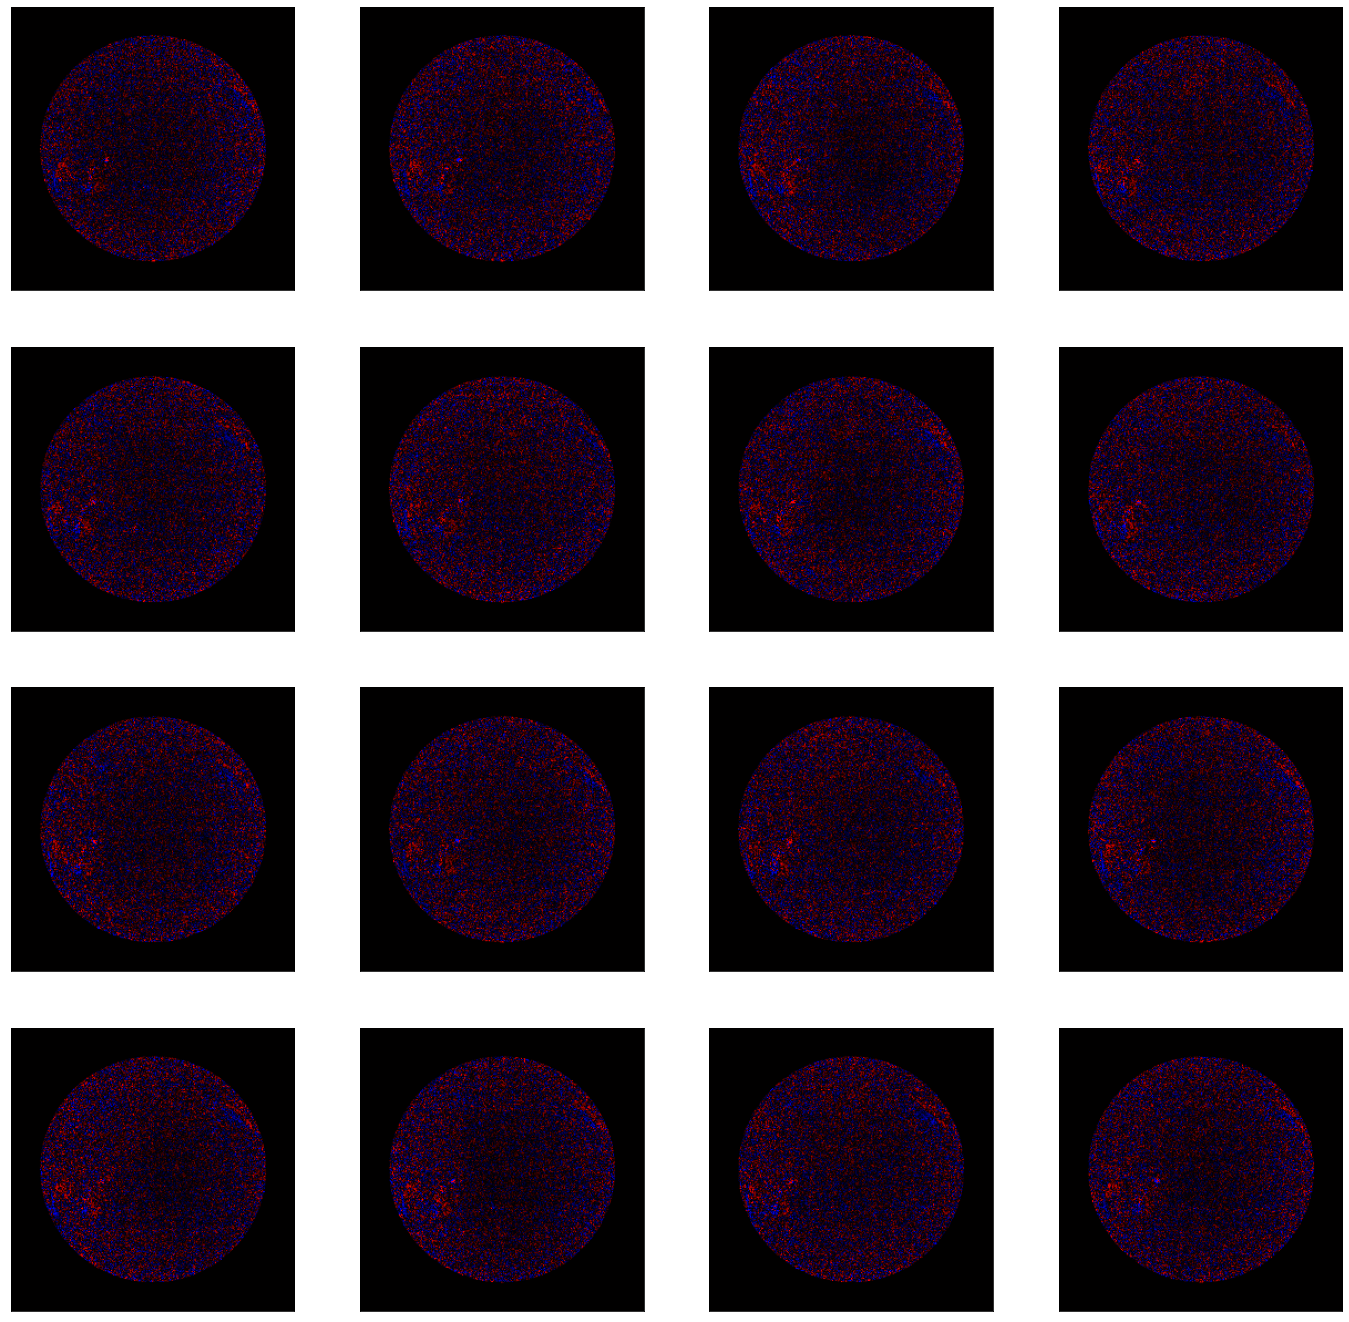

In [28]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map("Bx"), get_clip(x, "Bx"))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [29]:
y["T_OBS"]

['2010.08.28_17:48:05_TAI',
 '2010.08.28_22:00:05_TAI',
 '2010.08.28_12:00:05_TAI',
 '2010.08.28_00:00:05_TAI',
 '2010.08.28_04:00:05_TAI',
 '2010.08.28_23:00:05_TAI',
 '2010.08.28_05:48:05_TAI',
 '2010.08.28_01:00:05_TAI',
 '2010.08.28_05:00:05_TAI',
 '2010.08.28_20:00:05_TAI',
 '2010.08.28_02:00:05_TAI',
 '2010.08.28_17:00:05_TAI',
 '2010.08.28_13:00:05_TAI',
 '2010.08.28_16:00:05_TAI',
 '2010.08.28_03:00:05_TAI',
 '2010.08.28_21:00:05_TAI']

In [30]:
"""
Pytorch sampler that samples ordered indices from unordered sequences. 
Good for use with dask and RNN's, because 
1. Dask will slow down if sampling between chunks, so we must do one chunk at a time
2. RNN's need sequences so we must have seqences e.g. 1,2,3
3. But RNN's train better with batches that are uncorrelated so we want each batch to be sequence from a different part of a chunk.
For example, given each chunk is `range(12)`. Our seq_len is 3. We might end up with these indices:
- [[1,2,3],[9,10,11],[4,5,6]]
Usage:
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=SequenceInChunkSampler(train_dataset, seq_len=batch_size, chunksize=batch_size*100)
    )
"""
import torch.utils.data.sampler
import numpy as np
import pandas as pd


class SequenceInChunkSampler(torch.utils.data.sampler.Sampler):
    """
    Samples sequences of elements sequentially, but random sequences in a chunk.
    Arguments:
        data_source (Dataset): dataset to sample from
        seq_len (int): length of sequential sequences
        chunksize (int): length of cached data to take random sequences from
    url: https://gist.github.com/wassname/8ae1f64389c2aaceeb84fcd34c3651c3
    """

    def __init__(self, data_source, seq_len=6, chunksize=6000):
        assert chunksize % seq_len == 0, "chunk size should be a multiple of seq_len"
        assert len(data_source) > chunksize
        assert hasattr(data_source, 'attrs'), "data_source should have an attrs property"
        assert len(data_source) == len(data_source.attrs), "data source length has to equal attributes length"
        self.data_source = data_source
        self.seq_len = seq_len
        self.chunksize = chunksize
        t_obs = np.array(data_source.attrs["T_OBS"])
        df_time = pd.DataFrame(t_obs, index=np.arange(
            np.shape(t_obs)[0]), columns=["Time"])
        df_time["Time"] = pd.to_datetime(df_time["Time"], format=hmi_date_format, utc=True)
        

    def __iter__(self):
        chunk_idxs = np.arange(0, len(self.data_source), self.chunksize)
        max_i = len(self.data_source)
        print('max_i', max_i)

        for chunk_idx in chunk_idxs:
            seqs = np.arange(
                chunk_idx, min(chunk_idx + self.chunksize, max_i), self.seq_len
            )
            np.random.shuffle(seqs)
            for seq_i in seqs:
                for i in np.arange(seq_i, min(seq_i + self.seq_len, max_i)):
                    yield i

    def __len__(self):
        return len(self.data_source)


In [45]:
np.arange(np.shape(t_obs)[0])

IndexError: tuple index out of range

In [46]:
t_obs = np.array(y["T_OBS"])
data = {"Time": t_obs, "Index": np.arange(np.shape(t_obs)[0])}

df_time = pd.DataFrame(data, index=np.arange(np.shape(t_obs)[0]), columns=["Time", "Index"])
df_time["Time"] = pd.to_datetime(df_time["Time"], format=hmi_date_format, utc=True)
df_time = df_time.set_index('Time')

In [47]:
df_time

,Index
Time,
2010-08-28 17:48:05+00:00,0
2010-08-28 22:00:05+00:00,1
2010-08-28 12:00:05+00:00,2
2010-08-28 00:00:05+00:00,3
2010-08-28 04:00:05+00:00,4
2010-08-28 23:00:05+00:00,5
2010-08-28 05:48:05+00:00,6
2010-08-28 01:00:05+00:00,7
2010-08-28 05:00:05+00:00,8


In [32]:
np.arange(np.shape(t_obs)[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [19]:
df_time

""
Time
2010-08-28 05:00:05+00:00
2010-08-28 08:00:05+00:00
2010-08-28 09:00:05+00:00
2010-08-28 16:00:05+00:00
2010-08-28 23:00:05+00:00
2010-08-28 19:00:05+00:00
2010-08-28 03:00:05+00:00
2010-08-28 20:00:05+00:00
2010-08-28 17:48:05+00:00


In [48]:
grouped = df_time.groupby(pd.Grouper(freq='6h'))
grouped.groups

{Timestamp('2010-08-28 00:00:00+0000', tz='UTC', freq='6H'): 7,
 Timestamp('2010-08-28 06:00:00+0000', tz='UTC', freq='6H'): 7,
 Timestamp('2010-08-28 12:00:00+0000', tz='UTC', freq='6H'): 12,
 Timestamp('2010-08-28 18:00:00+0000', tz='UTC', freq='6H'): 16}

In [73]:
groups = dict(list(grouped))
groups

{Timestamp('2010-08-28 00:00:00+0000', tz='UTC', freq='6H'):                            Index
 Time                            
 2010-08-28 00:00:05+00:00      3
 2010-08-28 01:00:05+00:00      7
 2010-08-28 02:00:05+00:00     10
 2010-08-28 03:00:05+00:00     14
 2010-08-28 04:00:05+00:00      4
 2010-08-28 05:00:05+00:00      8
 2010-08-28 05:48:05+00:00      6,
 Timestamp('2010-08-28 06:00:00+0000', tz='UTC', freq='6H'): Empty DataFrame
 Columns: [Index]
 Index: [],
 Timestamp('2010-08-28 12:00:00+0000', tz='UTC', freq='6H'):                            Index
 Time                            
 2010-08-28 12:00:05+00:00      2
 2010-08-28 13:00:05+00:00     12
 2010-08-28 16:00:05+00:00     13
 2010-08-28 17:00:05+00:00     11
 2010-08-28 17:48:05+00:00      0,
 Timestamp('2010-08-28 18:00:00+0000', tz='UTC', freq='6H'):                            Index
 Time                            
 2010-08-28 20:00:05+00:00      9
 2010-08-28 21:00:05+00:00     15
 2010-08-28 22:00:05+00:00     

In [107]:
import random
import math

num_samples = len(df_time)
train_size = int(math.floor(num_samples*0.8))
val_size = int(math.ceil(num_samples*0.2))

grouped = df_time.groupby(pd.Grouper(freq='6h'))
groups = [(name, df) for name, df in grouped]
random.shuffle(groups)

train_indices = []
val_indices = []
for name, group in groups:
    if len(val_indices) < val_size:
        for row_index, row in group.iterrows():
            val_indices.append(row["Index"])
    elif len(train_indices) < train_size:
        for row_index, row in group.iterrows():
            train_indices.append(row["Index"])
    else:
        print("too much data")
        
        
print(len(val_indices) + len(train_indices))

16


In [91]:
if __name__ == '__main__':
    # Test
    seq_len = 3
    batch_size = 3
    chunksize = seq_len * batch_size * 2
    X_train = torch.arange(chunksize * 2).unsqueeze(-1)
    dataset_train = torch.utils.data.TensorDataset(X_train)
    print(len(dataset_train))
    dataset_train.attrs = {"T_OBS": ['2010.08.28_00:00:05_TAI',
 '2010.08.28_05:48:05_TAI',
 '2010.08.28_23:00:05_TAI',
 '2010.08.28_22:00:05_TAI',
 '2010.08.28_16:00:05_TAI',
 '2010.08.28_04:00:05_TAI',
 '2010.08.28_20:00:05_TAI',
 '2010.08.28_21:00:05_TAI',
 '2010.08.28_11:00:05_TAI',
 '2010.08.28_09:00:05_TAI',
 '2010.08.28_19:00:05_TAI',
 '2010.08.28_08:00:05_TAI',
 '2010.08.28_10:00:05_TAI',
 '2010.08.28_02:00:05_TAI',
 '2010.08.28_17:48:05_TAI',
 '2010.08.28_05:00:05_TAI']}
    loader_train = torch.utils.data.DataLoader(
        dataset_train,
        sampler=SequenceInChunkSampler(dataset_train, seq_len=seq_len, chunksize=chunksize),
        batch_size=batch_size * seq_len,
        drop_last=True
    )
    x,  = next(iter(loader_train))

    # View
    x = x.numpy().T
    xx = np.array(x).reshape(batch_size, seq_len)
    print(xx)
#     [[15. 16. 17.]
#      [ 6.  7.  8.]
#      [ 9. 10. 11.]]

    # Test
    assert (np.diff(xx) == 1).all(), 'does increase by one in sequences'
    assert (np.diff(x) != 1).any(), "doesn't increase by 1 at the border of sequences"
    assert (xx.max() - xx.min()) <= chunksize, 'total diff should be <= chunk_size'

9


AssertionError: 